In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

### Data load

In [2]:
X_train = np.load('data/PreBertFP/X_train_PreBertFP.npy',allow_pickle=True)
X_test = np.load('data/PreBertFP/X_test_PreBertFP.npy',allow_pickle=True)
X_val = np.load('data/PreBertFP/X_val_PreBertFP.npy',allow_pickle=True)

In [3]:
train = pd.read_csv('data/train.csv', delimiter=',')
test = pd.read_csv('data/test.csv', delimiter=',')
val = pd.read_csv('data/val.csv', delimiter=',')

In [4]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values

In [5]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
X_val = np.squeeze(X_val)

In [6]:
df_test1nn = pd.read_csv('data/PreBertFP/df_test1nn.csv', delimiter=',')

In [7]:
y_pred_test_1nn = np.load('data/PreBertFP/y_pred_test_1nn.npy')

### Evaluation

In [8]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [9]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [10]:
df_test1nn

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID
0,1085,0.952258,0.977890,0.964904,24966,185024,"Suzuki coupling, Suzuki-Miyaura Cross-Coupling","(ARCOUPLG)4.1.B, (AVNAMEDR)Suzuki-Miyaura"
1,432,0.892553,0.912790,0.902558,21259,164914,N-alkylation of alkylamines,(AG2ALKN)1.1.2
2,1016,0.885542,0.936480,0.910299,15507,113635,hydrolysis of carboxylic esters,(AQCLEAV1)1.1
3,60,0.906692,0.940009,0.923050,11185,85921,reduction of C-NO2 to C-NH2,(AAREDUCT)A.1
4,433,0.864972,0.874514,0.869717,7977,60554,"N-alkylation of benzenoid amines, anilines",(AG2ALKN)1.1.3
...,...,...,...,...,...,...,...,...
1294,1267,1.000000,1.000000,1.000000,1,8,Brackeen Imidazole Synthesis,(AVNAMEDR)Brackeen
1295,1800,0.000000,0.000000,0.000000,5,8,Shestakov Hydrazino Acid Synthesis,(AVNAMEDR)Shestakov
1296,500,0.000000,0.000000,0.000000,1,7,"O-propargylation of N-hydroxy amides, includin...",(AG2ALKO)2.4.1
1297,1622,0.000000,0.000000,0.000000,1,7,ListMacMillan Hydrogenation,(AVNAMEDR)List-MacMillan


In [11]:
df_test1nn['SUPER_TRANSFORM_ID'] = df_test1nn['TRANSFORM_ID'].str.extract(r'\((.*?)\)')

In [12]:
def weighted_mean(values, weights):
    return (values * weights).sum() / weights.sum()

In [13]:
grouped = df_test1nn.groupby('SUPER_TRANSFORM_ID')

grouped_metrics = grouped.apply(lambda x: pd.Series({
    'weighted_precision': weighted_mean(x['precision'], x['test_support']),
    'weighted_recall': weighted_mean(x['recall'], x['test_support']),
    'weighted_f1-score': weighted_mean(x['f1-score'], x['test_support']),
    'total_test_support': x['test_support'].sum(),
    'total_train_support': x['train_support'].sum(),
    'class_count': len(x)
}))

In [14]:
grouped_metrics.sort_values(by=['SUPER_TRANSFORM_ID'])

,weighted_precision,weighted_recall,weighted_f1-score,total_test_support,total_train_support,class_count
SUPER_TRANSFORM_ID,,,,,,
AAREDUCT,0.803098,0.809328,0.805795,36644.0,250984.0,53.0
ABOXIDAT,0.677883,0.668238,0.671989,24813.0,175151.0,105.0
ACADD,0.814000,0.804476,0.808679,15640.0,114981.0,37.0
ADELIMIN,0.785386,0.776995,0.780841,10650.0,67085.0,21.0
AEREARR,0.877156,0.851167,0.862157,2486.0,17393.0,36.0
AFCYCLIZ,0.843535,0.796324,0.818352,4026.0,31313.0,30.0
AG1ARYL,0.829620,0.797098,0.811905,7373.0,55032.0,20.0
AG2ALKC,0.802073,0.769010,0.782350,3840.0,26254.0,58.0
AG2ALKN,0.869125,0.880660,0.874731,35864.0,270086.0,16.0


In [15]:
# Calculate macro average for precision, recall, and f1-score
macro_precision2 = df_test1nn['precision'].mean()
macro_recall2 = df_test1nn['recall'].mean()
macro_f12 = df_test1nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision2 = (df_test1nn['precision'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_recall2 = (df_test1nn['recall'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_f12 = (df_test1nn['f1-score'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()

In [16]:
output1 = f"""
Macro-averages:
- Precision: {macro_precision2:.4f}
- Recall: {macro_recall2:.4f}
- F1-score: {macro_f12:.4f}

Weighted-averages:
- Precision: {weighted_precision2:.4f}
- Recall: {weighted_recall2:.4f}
- F1-score: {weighted_f12:.4f}
"""

In [17]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_1nn)}')

Accuracy: 0.8328043287687796


In [18]:
print(output1)


Macro-averages:
- Precision: 0.7646
- Recall: 0.7221
- F1-score: 0.7330

Weighted-averages:
- Precision: 0.8325
- Recall: 0.8328
- F1-score: 0.8319



In [19]:
summary_stats = df_test1nn[["precision", "recall", "f1-score", "test_support", "train_support"]].describe()
summary_stats

,precision,recall,f1-score,test_support,train_support
count,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000
mean,0.764627,0.722088,0.732964,254.665127,1851.890685
std,0.226378,0.233700,0.219207,1212.528218,9034.637418
min,0.000000,0.000000,0.000000,1.000000,7.000000
25%,0.680000,0.625000,0.666667,6.000000,39.000000
50%,0.809524,0.765957,0.780488,24.000000,160.000000
75%,0.916667,0.882353,0.875000,110.500000,811.000000
max,1.000000,1.000000,1.000000,24966.000000,185024.000000


In [20]:
low_f1_reactions = df_test1nn[df_test1nn['f1-score'] < df_test1nn['f1-score'].quantile(0.25)].head(10)

### Wrong predict evaluation in details

In [21]:
class_to_transform_id = pd.Series(df_class['TRANSFORM_NAME'].values,index=df_class['CLASS-ID']).to_dict()

In [22]:
y_pred_flattened = y_pred_test_1nn.flatten() 

In [23]:
mismatches = y_pred_flattened != y_test

full_comparison_df = pd.DataFrame({
    'CLASS-ID': y_test,
    'CLASS-ID-predict': y_pred_flattened,
    'Misclassified': mismatches
})

misclassified_df = full_comparison_df[full_comparison_df['Misclassified'] == True].sort_values(by=['CLASS-ID', 'CLASS-ID-predict'])

In [24]:
counts = misclassified_df.groupby(['CLASS-ID', 'CLASS-ID-predict']).size().reset_index(name='Count')
top_counts = (counts.sort_values(by=['CLASS-ID', 'Count'], ascending=[True, False])
             .groupby('CLASS-ID')
             .head(3))

In [25]:
reshaped_df = pd.DataFrame()
rows = []
for i, group in top_counts.groupby('CLASS-ID'):
    reshaped_row = {'CLASS-ID': i}
    for j, (index, row) in enumerate(group.iterrows(), start=1):
        reshaped_row[f'Top{j}_CLASS-ID-predict'] = row['CLASS-ID-predict']
        reshaped_row[f'Top{j}_Count'] = row['Count']
    rows.append(reshaped_row)

# Use concat instead of append
reshaped_df = pd.concat([reshaped_df, pd.DataFrame(rows)], ignore_index=True)

# Process columns as needed
reshaped_df = reshaped_df[['CLASS-ID'] + [col for col in reshaped_df.columns if col != 'CLASS-ID']].fillna(0).astype(int)

In [26]:
reshaped_df['Top1_MISTRANSFORM_NAME'] = reshaped_df['Top1_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top2_MISTRANSFORM_NAME'] = reshaped_df['Top2_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top3_MISTRANSFORM_NAME'] = reshaped_df['Top3_CLASS-ID-predict'].map(class_to_transform_id)

In [27]:
df_low = pd.merge(low_f1_reactions, reshaped_df[['CLASS-ID', 'Top1_MISTRANSFORM_NAME', 'Top1_Count', 'Top2_MISTRANSFORM_NAME', 'Top2_Count', 'Top3_MISTRANSFORM_NAME', 'Top3_Count']], on='CLASS-ID', how='left')

In [28]:
df_low

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID,SUPER_TRANSFORM_ID,Top1_MISTRANSFORM_NAME,Top1_Count,Top2_MISTRANSFORM_NAME,Top2_Count,Top3_MISTRANSFORM_NAME,Top3_Count
0,5,0.613999,0.664854,0.638415,3127,23357,reduction of aldehydes to alcohols,(AAREDUCT)1.1.1,AAREDUCT,oxidative fission of alkenes to aldehydes,98,"Dess-Martin aldehyde synthesis, Dess-Martin ox...",54,"Swern aldehyde synthesis, Swern oxidation of a...",51
1,109,0.580533,0.608748,0.594306,1646,12611,"Dess-Martin ketone synthesis, Dess-Martin oxid...","(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",ABOXIDAT,Corey-Suggs Reagent,72,"Dess-Martin aldehyde synthesis, Dess-Martin ox...",37,-OR -H elimination to C=C,37
2,86,0.630070,0.639057,0.634532,1823,12339,oxidative fission of alkenes to aldehydes,(ABOXIDAT)2.5.1,ABOXIDAT,reduction of aldehydes to alcohols,140,Lindgren-Pinnick oxidation of aldehydes to car...,34,"Dess-Martin aldehyde synthesis, Dess-Martin ox...",33
3,1331,0.557025,0.606479,0.580701,1667,12096,Corey-Suggs Reagent,(AVNAMEDR)Corey-Suggs,AVNAMEDR,reduction of aldehydes to alcohols,64,"Swern aldehyde synthesis, Swern oxidation of a...",63,"Dess-Martin ketone synthesis, Dess-Martin oxid...",63
4,99,0.521588,0.518339,0.519958,1445,10979,"Dess-Martin aldehyde synthesis, Dess-Martin ox...","(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",ABOXIDAT,reduction of aldehydes to alcohols,75,"Swern aldehyde synthesis, Swern oxidation of a...",72,Corey-Suggs Reagent,53
5,805,0.674948,0.581624,0.624820,1121,8648,Appel halogenation,"(AG9HALOG)1.1, (AVNAMEDR)Appel1",AG9HALOG,reduction of aldehydes to alcohols,56,"N-alkylation of ammonia, amination of sp3 carbon",35,Corey-Suggs Reagent,30
6,97,0.509108,0.542945,0.525482,978,7239,"Swern aldehyde synthesis, Swern oxidation of a...","(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",ABOXIDAT,"Dess-Martin aldehyde synthesis, Dess-Martin ox...",72,Corey-Suggs Reagent,57,reduction of aldehydes to alcohols,39
7,177,0.611940,0.609840,0.610888,874,6914,oxidation of alkyl aryl sulfides to sulfoxides,(ABOXIDAT)K.1.3,ABOXIDAT,oxidation of alkyl aryl sulfides to sulfones,152,oxidation of dialkyl sulfides to sulfoxides,15,sulfoxides to sulfides,13
8,176,0.571066,0.561097,0.566038,802,6355,oxidation of dialkyl sulfides to sulfoxides,(ABOXIDAT)K.1.2,ABOXIDAT,oxidation of dialkyl sulfides to sulfones,144,oxidation of alkyl aryl sulfides to sulfoxides,22,sulfoxides to sulfides,11
9,129,0.558252,0.592021,0.574641,777,5347,Lindgren-Pinnick oxidation of aldehydes to car...,"(ABOXIDAT)6.2.1, (AVNAMEDR)Pinnick-Lindgren",ABOXIDAT,reduction of aldehydes to alcohols,45,oxidative fission of alkenes to aldehydes,41,"Dess-Martin aldehyde synthesis, Dess-Martin ox...",34


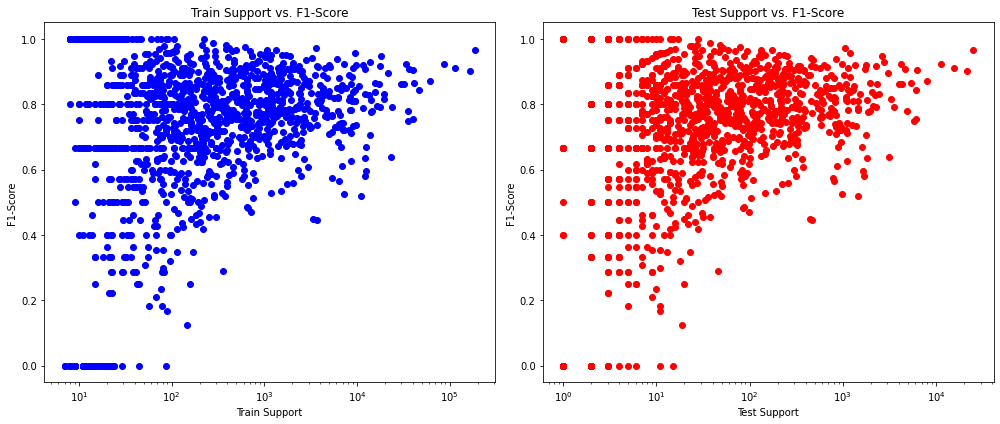

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(df_test1nn['train_support'], df_test1nn['f1-score'], color='blue')
ax1.set_title('Train Support vs. F1-Score')
ax1.set_xlabel('Train Support')
ax1.set_ylabel('F1-Score')
ax1.set_xscale('log')  # Set x-axis to log scale

ax2.scatter(df_test1nn['test_support'], df_test1nn['f1-score'], color='red')
ax2.set_title('Test Support vs. F1-Score')
ax2.set_xlabel('Test Support')
ax2.set_ylabel('F1-Score')
ax2.set_xscale('log')  # Set x-axis to log scale

plt.tight_layout()
plt.show()

### Manual test(Will be improved)

In [270]:
Manually_input = 'CC(=O)OC(\\C=C\\c1ccccc1)C#N>>CC(=O)OC(CC(=O)c1ccccc1)C#N'